In [2]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from django.db.models import Count, Avg
from multiprocess import Pool
from functools import partial
import numpy as np
from functools import partial
from scipy.sparse import coo_matrix, csr_matrix, find, tril
import networkx as nx
import csv

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
qid = 1603

In [3]:
runs = list(range(352,362))
runs

[352, 353, 354, 355, 356, 357, 358, 359, 360, 361]

In [7]:

fname = "../data/topic_data/run_{}.xlsx".format(runs[0])

writer = pd.ExcelWriter(fname)

for i in range(1,len(runs)):

    topics1 = Topic.objects.filter(run_id=runs[i-1])
    topics2 = Topic.objects.filter(run_id=runs[i])

    df = pd.DataFrame.from_dict(list(topics2.values('title','id')))
    df['similarity'] = 0
    df['stopic'] = ""

    for t in topics2:
        scores = [0]
        titles = [""]
        t.top_words = list(Term.objects.filter(topicterm__topic=t).order_by('topicterm__score').values_list('title',flat=True))
        for ct in topics1:
            ct.top_words = list(Term.objects.filter(
                topicterm__topic=t
            ).order_by('topicterm__score').values_list('title',flat=True))
            score = len(set(t.top_words).intersection(set(ct.top_words)))
            if score>0:
                scores.append(score)
                titles.append(ct.title)

        
        m = max(scores)
        df.loc[df['id']==t.id,'similarity'] = m
        df.loc[df['id']==t.id,'stopic'] = titles[scores.index(max(scores))]


    df = df.sort_values('similarity',ascending=False)
    df.head()
    
    
    

    
    df.to_excel(writer,"run_{}".format(runs[i]))
    
writer.save()

In [3]:


writer = pd.ExcelWriter(fname)
fname = "../data/topic_data/run_{}.xlsx".format(runs[0])

dynamic = True

for i in range(1,len(runs)):
    
    if dynamic==True:
        topics1 = DynamicTopic.objects.filter(run_id=runs[i-1])
        topics2 = DynamicTopic.objects.filter(run_id=runs[i])
    else:
        topics1 = Topic.objects.filter(run_id=runs[i-1])
        topics2 = Topic.objects.filter(run_id=runs[i])       

    df = pd.DataFrame.from_dict(list(topics2.values('title','id')))
    df['similarity'] = 0
    df['stopic'] = ""

    for t in topics2:
        scores = [0]
        titles = [""]
        for ct in topics1:
            score = len(set(t.top_words).intersection(set(ct.top_words)))
            if score>0:
                scores.append(score)
                titles.append(ct.title)

        
        m = max(scores)
        df.loc[df['id']==t.id,'similarity'] = m
        df.loc[df['id']==t.id,'stopic'] = titles[scores.index(max(scores))]


    df = df.sort_values('similarity',ascending=False)
    df.head()
    
    
    
    
    

    
    df.to_excel(writer,"run_{}".format(runs[i]))
    
writer.save()

In [ ]:

#runs = [295,296,297

runs = list(range(352,362))
runs

col1s = []
col2s = []
ss = []
scols = []

for i in range(1,len(runs)):

    topics1 = Topic.objects.filter(run_id=runs[i-1])
    topics2 = Topic.objects.filter(run_id=runs[i])
    

    df = pd.DataFrame.from_dict(list(topics2.values('title','score')))
    
    df2 = pd.DataFrame.from_dict([{'title': 'None','score': 0}])
    
    df = df.append(df2)

    
    
    col1 = "run_{}_topics_{}".format(runs[i-1],topics1.count())
    
    scol = "scores_{}".format(runs[i])
    bscol = "scores_{}".format(runs[i-1])
    
    if i==1:
        scols.append(bscol)
    
    col1s.append(col1)
    scols.append(scol)
    
    col2 = "run_{}_topics_{}".format(runs[i], topics2.count())
    
    col2s.append(col2) 
    
    s = "similarity_{}-{}".format(runs[i-1],runs[i])
    ss.append(s)
    
    df = df.rename(columns = {'title': col2, 'score': scol})

    df[s] = 0
    df[col1] = "None"
    df[bscol] = 0

    for t in topics2:
        t.top_words = list(Term.objects.filter(
                topicterm__topic=t
            ).order_by('-topicterm__score').values_list('title',flat=True))[:10]
        scores = [0]
        titles = [""]
        tscores = [0]
        for ct in topics1:
            ct.top_words = list(Term.objects.filter(
                topicterm__topic=ct
            ).order_by('-topicterm__score').values_list('title',flat=True))[:10]
            score = len(set(t.top_words).intersection(set(ct.top_words)))
            if score>0:
                scores.append(score)
                titles.append(ct.title)
                tscores.append(ct.score)

        
        m = max(scores)
        df.loc[df[col2]==t.title, s] = m
        if m==0:
            df.loc[df[col2]==t.title, col1] = 'None'
        else:
            df.loc[df[col2]==t.title, col1] = titles[scores.index(max(scores))]
            df.loc[df[col2]==t.title, bscol] = tscores[scores.index(max(scores))]
            

    if i==1:   
        #df = pd.DataFrame.from_dict(list(topics2.values('title')))
        mdf = df
    else:
        mdf = mdf.merge(df,how="outer").fillna("")
    

columns = []
for i in range(len(col1s)):
    columns.append(col1s[i])
    columns.append(scols[i])
    columns.append(ss[i])
    if i == len(col1s)-1:
        columns.append(col2s[i])
        columns.append(scols[i+1])

print(columns)

mdf = mdf[columns]

mdf.head()



In [20]:
#col1s.append(col2)


#mdf = mdf.sort_values(columns,ascending=False).reset_index()


res = mdf.groupby(columns)



res = res.apply(lambda x: x.sort_values(s,ascending=False))

l = len(res)




fname = "../data/topic_data/run_compare_{}_{}.xlsx".format(runs[0],runs[len(runs)-1])

writer = pd.ExcelWriter(fname, engine='xlsxwriter')

res.to_excel(writer)

worksheet = writer.sheets['Sheet1']

for i in range(len(ss)):
    if (i+1)*3 > 26:
        c = 'A'+chr(ord('A')-1+((i+1)*3)-26)
    else:
        c = chr(ord('A')-1+(i+1)*3)
    r = "{}2:{}{}".format(c,c,len(res))
    print(r)
    
    worksheet.conditional_format(r, {
        'type': '3_color_scale',
        'min_value': 0,
        'mid_value': 5,
        'max_value': 10,
        'min_type': 'num',
        'mid_type': 'num',
        'max_type': 'num',
    })

writer.save()

res.head() 
    
    
res.head()

C2:C50
F2:F50
I2:I50
L2:L50


run_352_topics_20  \
run_352_topics_20 scores_352 similarity_352-353 run_353_topics_21 scores_353 similarity_353-354 run_354_topics_22 scores_354 similarity_354-355 run_355_topics_23 scores_355 similarity_355-356 run_356_topics_24            scores_356                        
None              0.0        0                  None              0.0        0.0                None              0.0        0.0                None              0.0        0.0                None                         0.000000   49              None   
                                                                                                                                                                                                {air, ventil, indoor}        47.821940  45              None   
                                                                                                                                                                                                {develop, sustain, govern}   127.695947 47              None   
                                                                                                                                                                                                {health, activ, walk}        87.263333  43              None   
                                                                                                                                                                                                {recycl, household, collect} 30.869957  44              None   

                                                                                                                                                                                                                                            scores_352  \
run_352_topics_20 scores_352 similarity_352-353 run_353_topics_21 scores_353 similarity_353-354 run_354_topics_22 scores_354 similarity_354-355 run_355_topics_23 scores_355 similarity_355-356 run_356_topics_24            scores_356                  
None              0.0        0                  None              0.0        0.0                None              0.0        0.0                None              0.0        0.0                None                         0.000000   49         0.0   
                                                                                                                                                                                                {air, ventil, indoor}        47.821940  45         0.0   
                                                                                                                                                                                                {develop, sustain, govern}   127.695947 47         0.0   
                                                                                                                                                                                                {health, activ, walk}        87.263333  43         0.0   
                                                                                                                                                                                                {recycl, household, collect} 30.869957  44         0.0   

                                                                                                                                                                                                                                            similarity_352-353  \
run_352_topics_20 scores_352 similarity_352-353 run_353_topics_21 scores_353 similarity_353-354 run_354_topics_22 scores_354 similarity_354-355 run_355_topics_23 scores_355 similarity_355-356 run_356_topics_24            scores_356                          
None              0.0        0                  None              0.0        0.0                None              0.0        0.0                None              0.0        0.

In [ ]:
print(mdf)

In [ ]:
runs = list(range(295,300))

runs = []

for i in range(len(runs)):

    topics = Topic.objects.filter(run_id=runs[i])
    
    tree = []
    
    for t in topics:
        
        tdict = {
            "parent_similarity": 0,
            "run": runs[i],
            "ntopics": topics.count(),
            "title": t.title,
            "sim_topics": [],
            "child_topics": 0
        }
        
        if i==0:
            tree.append(tdict)
        else:
            
            scores = [0]
            titles = [""]
            for ct in comparison_topics:
                score = len(set(t.top_words).intersection(set(ct.top_words)))
                if score>0:
                    scores.append(score)
                    titles.append(ct.title)


                parent = titles[scores.index(max(scores))]
                
                
                
                print(m)

In [143]:
run_id = 337

run = RunStats.objects.get(pk=run_id)

dts = DocTopic.objects.filter(
    run_id=run_id,
    doc__content__iregex='\w'
).values('doc__PY').annotate(
    n = Count('doc', distinct=True),
    k = Count('topic', distinct=True)
)

df =  pd.DataFrame.from_dict(list(dts))

df.tail()

,doc__PY,k,n
19,2009,80,7143
20,2010,79,8239
21,2011,81,9846
22,2012,88,11334
23,2013,94,13813


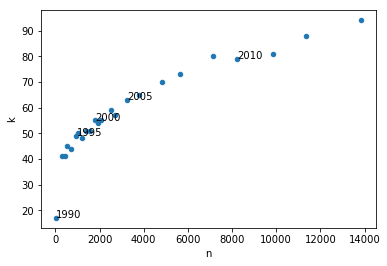

In [144]:

ax = df.plot.scatter('n','k')

list(df.k)

for index, row in df.iterrows():
    if row['doc__PY'] % 5 ==0:
        ax.text(row['n'],row['k'],row['doc__PY'])



plt.show()

In [97]:
qid = run.query.id
y = 1990
docs = Doc.objects.filter(query=qid,relevant=True,content__iregex='\w',PY=y)


docs.distinct().count()

37